<a href="https://colab.research.google.com/github/chrisfinan/GenAI/blob/main/HW3/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Chris Finan
> 10/11/24

> Assignment 3

#Description
* In this assignment, you will create and train a Variational Autoencoder (VAE) model in Keras to learn representations of the Street View House Numbers (SVHN) dataset and explore its performance with different latent dimensions.
* The SVHN dataset is often used for evaluating machine learning algorithms, particularly in the field of computer vision (http://ufldl.stanford.edu/housenumbersLinks)
* It consists of labeled digits extracted from natural images of house numbers collected from Google Street View.
* Each image in the dataset is 32x32 pixels and contains a single digit, ranging from 0 to 9, often presented in varying orientations, backgrounds, and lighting conditions.
* The dataset is divided into a training set, which contains around 73,000 samples, and a test set with over 26,000 samples.
* The SVHN dataset presents a challenge because of the cluttered backgrounds and the variability in digit styles.

##Task 1: Load and Preprocess the SVHN Dataset

* Use the commands provided to download and load the SVHN dataset.

* Preprocess the images (normalize and reshape).

* Display the shape of the training and test datasets.

In [7]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

--2024-10-11 21:10:00--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  4.40MB/s    in 36s     

2024-10-11 21:10:36 (4.76 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2024-10-11 21:10:36--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  7.12MB/s    in 9.9s    

2024-10-11 21:10:46 (6.17 MB/s) - ‘test_32x32.mat.1’ saved [642

##Task 2: Build a Variational Autoencoder

* Define the encoder and decoder architecture for the VAE.

* Create the complete VAE model using the function: build_vae(latent_dim)

* Ensure it can take a specified latent dimension.

In [8]:
IMAGE_SIZE = 32
BETA = 500

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""

        if isinstance(data, tuple):
          data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
def build_vae(latent_dim):
    # Encoder
  encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input")
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

  x = layers.Flatten()(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()

    # Decoder
  decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
  x = layers.Reshape(shape_before_flattening)(x)
  x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  decoder_output = layers.Conv2D(
      3,
      (3, 3),
      strides=1,
      activation="sigmoid",
      padding="same",
      name="decoder_output",
  )(x)

  decoder = models.Model(decoder_input, decoder_output)
  decoder.summary()

  vae = VAE(encoder, decoder)
  return vae


##Task 3: Train the VAE with Different Latent Dimensions

* Train the VAE with latent dimensions of 2, 5, and 10. Use the following for-loop in main:

In [12]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                      

###Monitor the training process and evaluate the model's performance.
> Latent Dimension: 2
* Epoch 1/50 (33s - 54ms/step) - total_loss: 325.2173 - reconstruction_loss: 322.9354 - kl_loss: 2.2817 - val_loss: 316.3261 - val_reconstruction_loss: 313.3581 - val_kl_loss: 2.9680
* Epoch 50/50 (29s 51ms/step) - total_loss: 320.5125 - reconstruction_loss: 317.4348 - kl_loss: 3.0779 - val_loss: 315.8467 - val_reconstruction_loss: 312.5762 - val_kl_loss: 3.2705

> Latent Dimension: 5
* Epoch 1/50 (32s 52ms/step) - total_loss: 325.2164 - reconstruction_loss: 322.3473 - kl_loss: 2.8690 - val_loss: 315.0533 - val_reconstruction_loss: 310.7616 - val_kl_loss: 4.2917
* Epoch 50/50 (29s 50ms/step) - total_loss: 318.7607 - reconstruction_loss: 314.0933 - kl_loss: 4.6675 - val_loss: 314.0049 - val_reconstruction_loss: 308.7147 - val_kl_loss: 5.2902

> Latent Dimension: 10
* Epoch 1/50 (32s 52ms/step) - total_loss: 326.2074 - reconstruction_loss: 323.3667 - kl_loss: 2.8409 - val_loss: 315.2296 - val_reconstruction_loss: 311.0064 - val_kl_loss: 4.2232
* Epoch 50/50 (29s 51ms/step) - total_loss: 318.5328 - reconstruction_loss: 313.2142 - kl_loss: 5.3189 - val_loss: 313.2411 - val_reconstruction_loss: 307.4590 - val_kl_loss: 5.7821

Looking at all of the latent dimensions, the results are very similar for the most part. The largest latent dimension, in this case, has the lowest final values on epoch 50 for total loss, reconstruction loss, validation loss, and validation reconstruction loss. The numbers are close, but latent dimension 10 produces the best results in these categories. However, latent dimension 10 produces the largest kl loss values compared to the other two. Dimension 2 has the lowest kl loss values and the highest in other categories. Dimension 10 is the opposite and 5 is simply in the middle. It took around an hour and a half to run all three sets of 50 epochs.

##Task 4: Visualize the Results

* Create visualizations of original and reconstructed images for the largest latent dimension.

* Optionally, visualize the latent space representations.

814/814 [==============================] - 6s 7ms/step


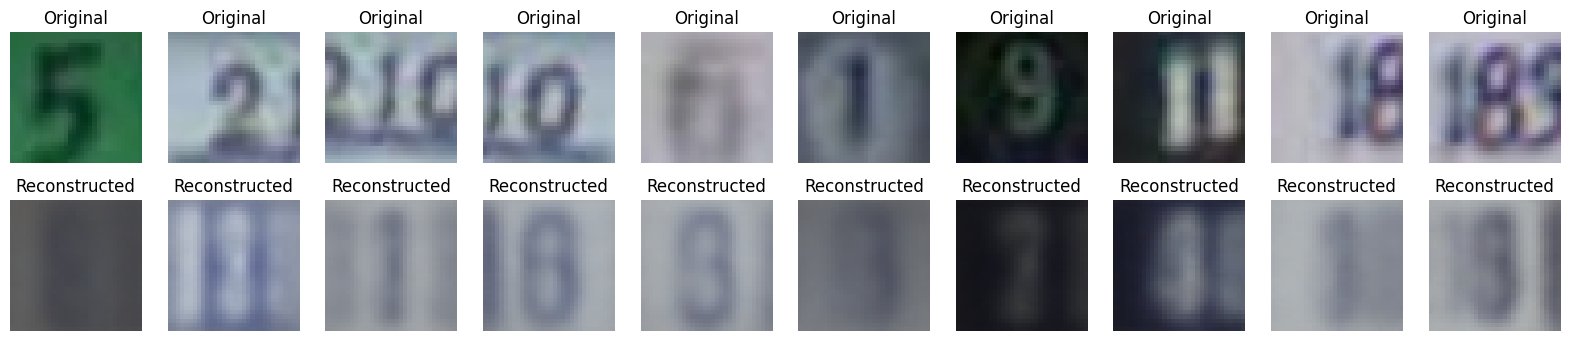

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Largest latent dimension was used last - we can visualize largest without adjusting
# Pass the test images through the encoder and decoder to get reconstructions
z_mean, z_log_var, z = vae.encoder.predict(x_test)  # Encoder output
reconstructions = vae.decoder.predict(z)  # Decoder output (reconstructed images)

# Images to visualize
num_images = 10
image_size = x_test.shape[1]

# Plot original and reconstructed images
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(x_test[i].reshape(image_size, image_size, 3))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images
    axes[1, i].imshow(reconstructions[i].reshape(image_size, image_size, 3))
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.show()


Looking at the generated vs. original images, there are obviously some discrepancies. The reconstructed images are definitely blurrier, but they are still somewhat readable to the human eye. Image 4 looks like it was able to reconstruct another 10. Image 8 clearly has an 11 in both reconstruction and original, even though the reconstruction is distorted. For most of the images you can tell that they were reconstructed from their original pair.

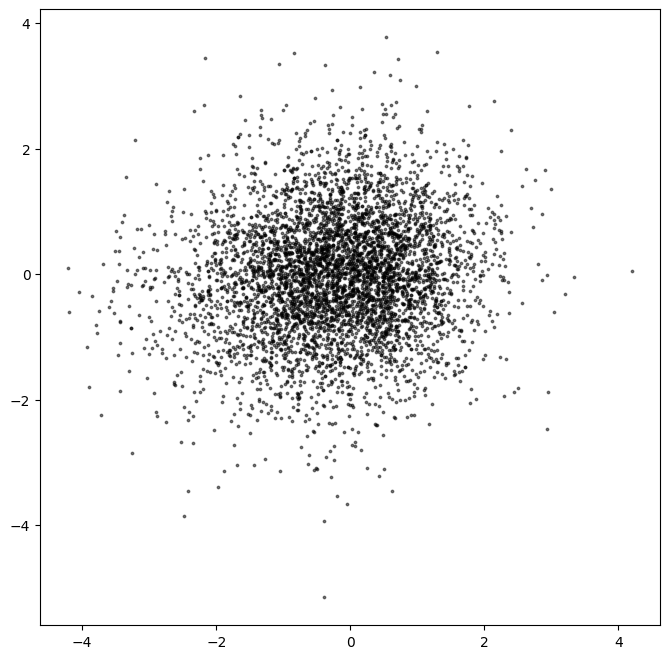

In [18]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

The 2D representation of the latent space here shows that every point forms one large cluster. It can be hard to distinguish between blurry pictures of different combinations of numbers.

1/1 [==============================] - 0s 30ms/step


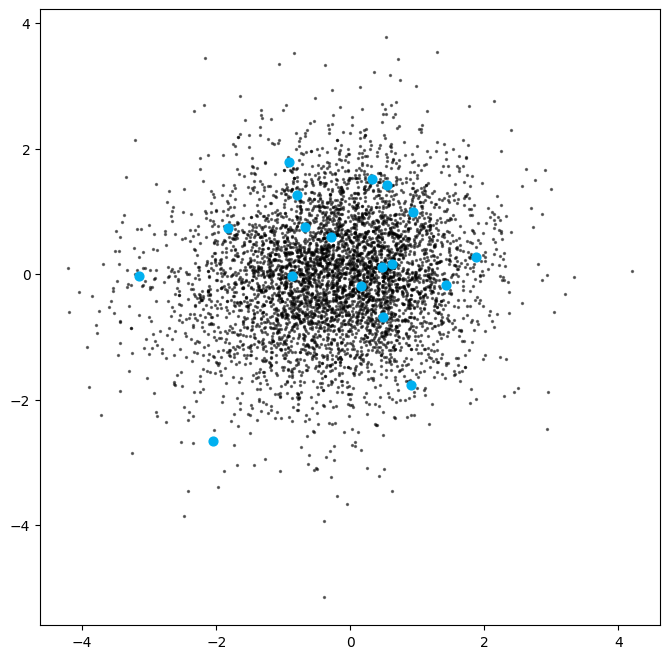

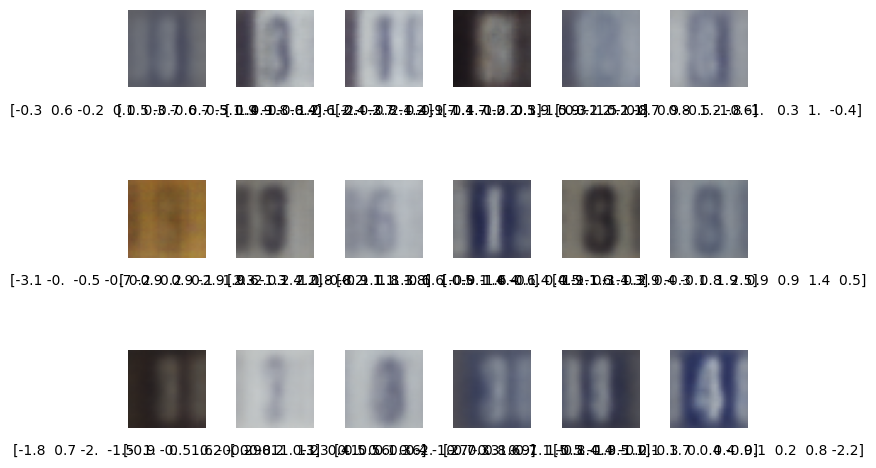

In [19]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 10))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

These numbers above are generated by the decoder and plotted in the latent space. Some of the numbers look similar, but it is stil hard to distinguish between them. The values are a bit sloppy within this picture here. The decoder seems to maintain a consistent performance with similar digits. For example, the 3's, 8's, and 6's in these images here follow the same style. The different backgrounds seem to throw off the image generation, with some numbers appearing clearer than others.

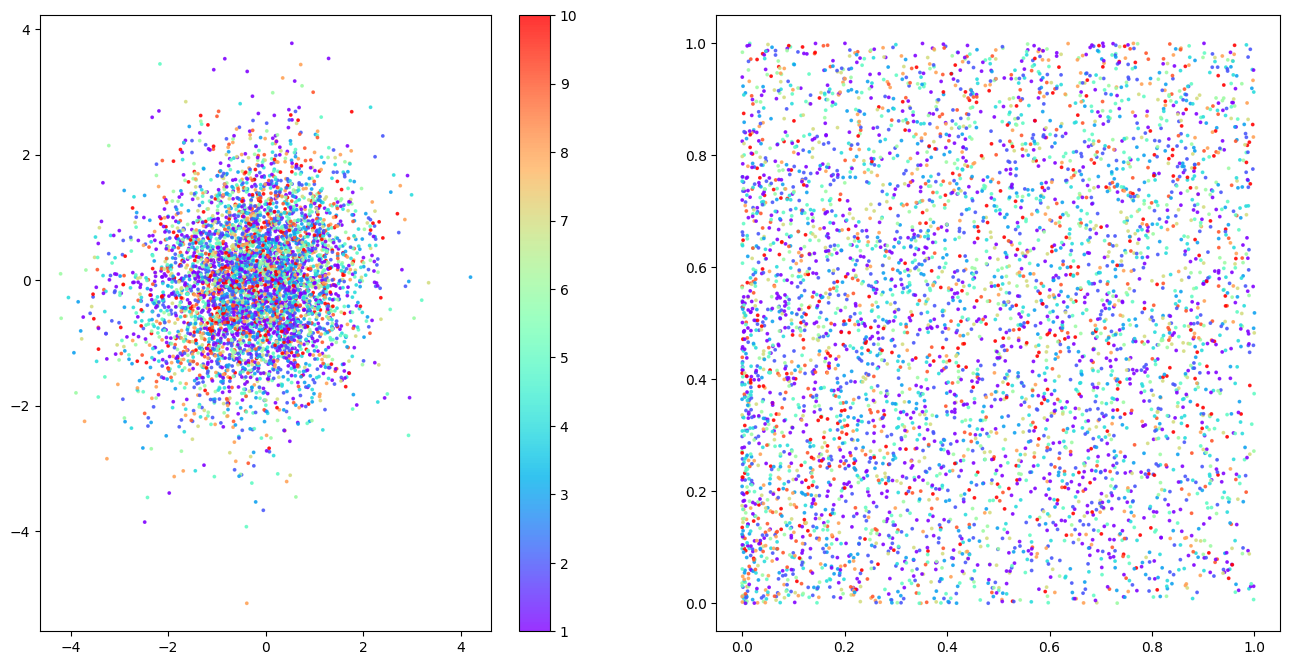

In [20]:
# Colour the embeddings by their label
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Looking further into the latent space, you can see that all of the numbers are scattered around the plot and there is no clear clusters separating them. The colors give a better representation compared to the black and white latent space.

8/8 [==============================] - 0s 5ms/step


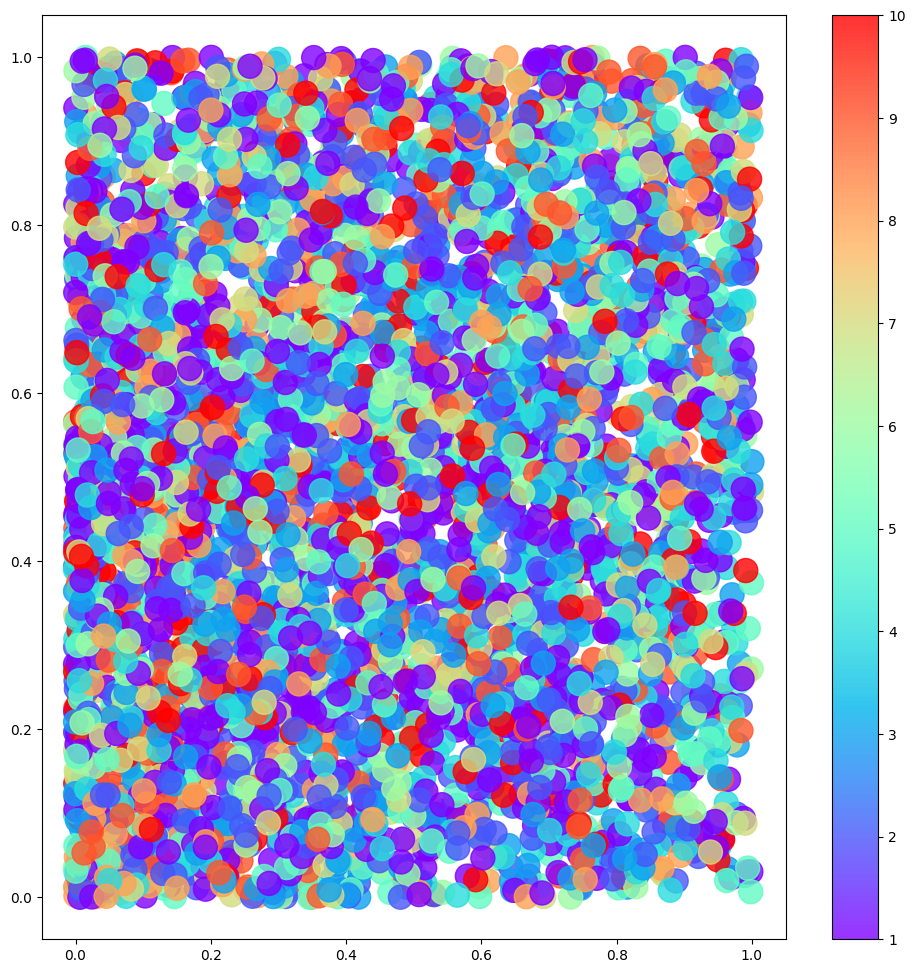

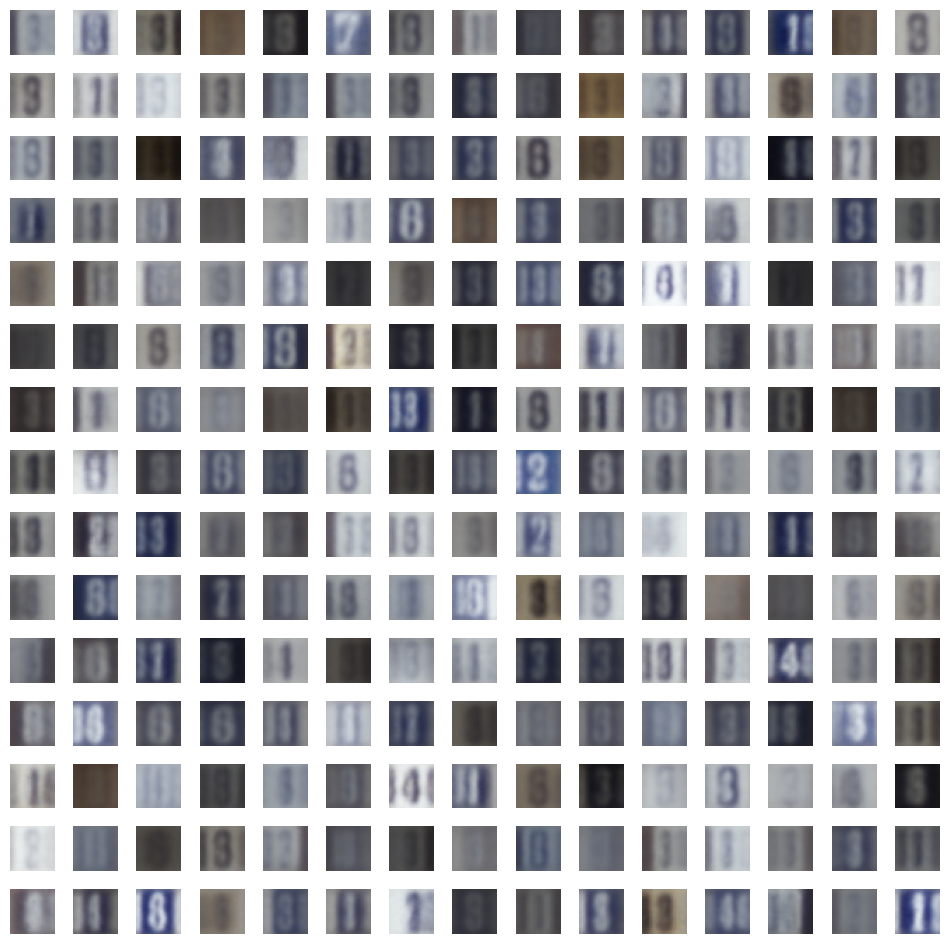

In [21]:
# Colour the embeddings by their label
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.random.normal(size=(grid_size * grid_size, 10))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Once again here are more examples of the reconstructed images as well as the latent space representations. There is no defined sets of colors grouped together. All of the images here reinforce the idea that they are not properly categorized and the decoder has a tough time distinguishing them when regenerating. This particular model hasn't fully gained the ability to generate mostly coherent images and therefore hasn't fully recognized the distribution.

##Conclusion
* Using a batch size of 128 and 50 epochs is not optimal for this data set because it is difficult for the model to distinguish between the different blurry numbers, especially when certain numbers look similar at lower qualities. I also tested a batch size of 64 and 100 epochs, but I kept timing out before the 3 epochs completed so I decided not to include the code in my report. Using 64 and 100 did not cause any significant improvements in the loss. The results were around the same. Throughout the 50 epochs in my main testing model, the losses only changed slightly. The kl losses went up or fluctuated while the other losses kept going down very slowly. To get better reconstructions with this data set, I would need to change the parameters significantly to see any changes. This model would be able to improve the most by recognizing the outline and edges of different numbers.

### Reference
* https://github.com/bforoura/GenAI/blob/main/Module3/vae_fashion.ipynb